# Inferring $R_t$ values from pyEpiabm using an SEIR model

In this notebook we use prevalence and incidence rates from pyEpiabm to infer the $\beta$, $\gamma$ and $\kappa$ values of the
SEIR model using `seirmo`. We then use $\beta$, $\gamma$ and $\kappa$  to calculate $R_t$ and then compare it to the true underlying
values.

## Plotting output data from the Northern Ireland simulation

This notebook takes data from the NI_example of pyEpiabm.

This simulation was run over 90 days with a total population of 1837198 and initial infected number of 100.

### SIR Plot for Northern Ireland

![SIR Plot](NI_outputs/r_1/simulation_flow_SIR_plot.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

Day 0
Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Day 8
Day 9
Day 10
Day 11
Day 12
Day 13
Day 14
Day 15
Day 16
Day 17
Day 18
Day 19
Day 20
Day 21
Day 22
Day 23
Day 24
Day 25
Day 26
Day 27
Day 28
Day 29
Day 30
Day 31
Day 32
Day 33
Day 34
Day 35
Day 36
Day 37
Day 38
Day 39
Day 40
Day 41
Day 42
Day 43
Day 44
Day 45
Day 46
Day 47
Day 48
Day 49
Day 50
Day 51
Day 52
Day 53
Day 54
Day 55
Day 56
Day 57
Day 58
Day 59
Day 60
Day 61
Day 62
Day 63
Day 64
Day 65
Day 66
Day 67
Day 68
Day 69
Day 70
Day 71
Day 72
Day 73
Day 74
Day 75
Day 76
Day 77
Day 78
Day 79
Day 80
Day 81
Day 82
Day 83
Day 84
Day 85
Day 86
Day 87
Day 88
Day 89
Day 90


Text(0.5, 1.0, 'Underlying prevalence for Northern Ireland simulation')

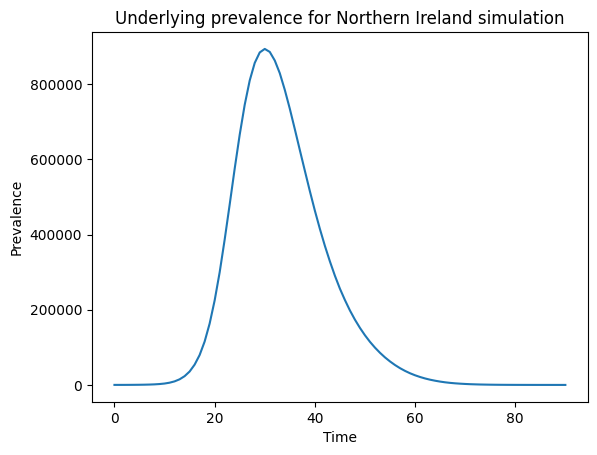

In [2]:
seir_data = pd.read_csv("NI_outputs/r_1/inf_status_history.csv", dtype="int8", low_memory=False)
times = seir_data["time"]
# Get the true result from seir_data
susceptible_list = []
exposed_list = []
infected_list = []
recovered_list = []
for t in range(91):
    print(f"Day {t}")
    num = seir_data.iloc[t, 1:].value_counts().get(3, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(4, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(5, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(6, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(7, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(8, 0)
    susceptible_list.append(seir_data.iloc[t, 1:].value_counts().get(1, 0))
    exposed_list.append(seir_data.iloc[t, 1:].value_counts().get(2, 0))
    infected_list.append(num)
    recovered_list.append(seir_data.iloc[t, 1:].value_counts().get(9, 0) + seir_data.iloc[t, 1:].value_counts().get(10, 0))
susceptible = np.array(susceptible_list)
exposed = np.array(exposed_list)
infected = np.array(infected_list)
recovered = np.array(recovered_list)
plt.plot(times, infected)
plt.xlabel("Time")
plt.ylabel("Prevalence")
plt.title("Underlying prevalence for Northern Ireland simulation")

Text(0.5, 1.0, 'Underlying prevalence for Ireland simulation, r = 1')

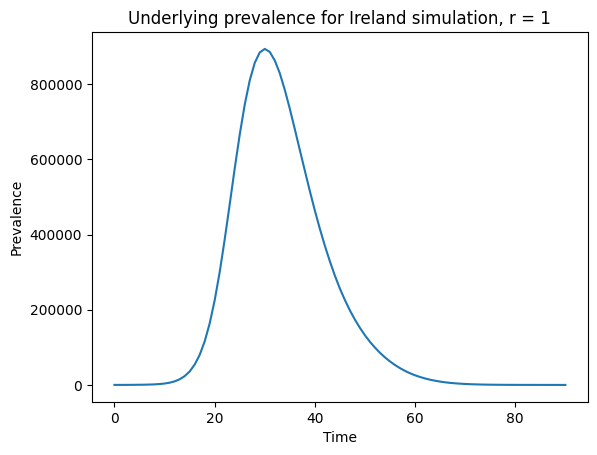

In [4]:
plt.plot(times, infected)
plt.xlabel("Time")
plt.ylabel("Prevalence")
plt.title("Underlying prevalence for Ireland simulation, r = 1")

In [5]:
small_seir = pd.DataFrame({"Susceptible": susceptible, "Exposed": exposed, "Infected": infected, "Recovered": recovered})
small_seir.to_csv("NI_outputs/r_1/seir.csv")

In [6]:
small_seir_df = pd.read_csv("NI_outputs/r_1/seir.csv", index_col=0)
susceptible = small_seir_df["Susceptible"]
exposed = small_seir_df["Exposed"]
infected = small_seir_df["Infected"]
recovered = small_seir_df["Recovered"]

### Create $R_t$ plot

Simulations in pyEpiabm produce true $R_t$ values for each time step in a file named `secondary_infections.csv`. 

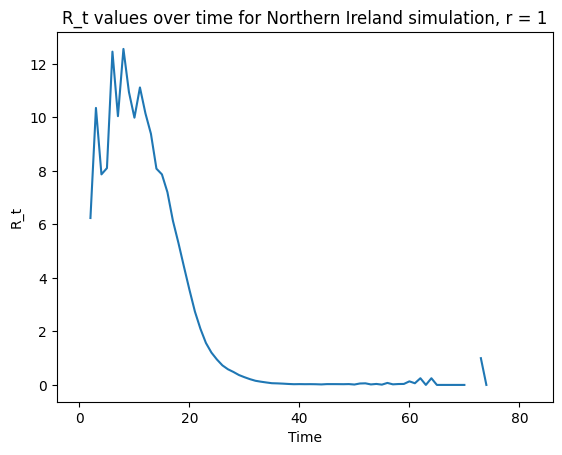

<Figure size 640x480 with 0 Axes>

In [7]:
secondary_infections_data = pd.read_csv("NI_outputs/r_1/secondary_infections.csv", dtype="float32", low_memory=False)
plt.plot(secondary_infections_data["time"], secondary_infections_data["R_t"])
plt.xlabel("Time")
plt.ylabel("R_t")
plt.title("R_t values over time for Northern Ireland simulation, r = 1")
plt.show()
plt.savefig("NI_outputs/r_1/simulation_flow_R_t.png")

### Create secondary infections histogram

This file also contains data for the secondary infections of each person.

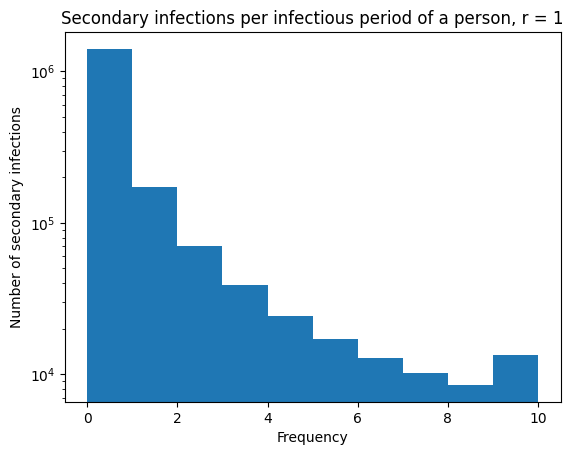

<Figure size 640x480 with 0 Axes>

In [8]:
secondary_infections_data.dropna()
secondary_infections_only = secondary_infections_data.iloc[:, 2:-1].to_numpy()
secondary_infections_array = secondary_infections_only.flatten()
plt.hist(secondary_infections_array, range=(0, 10), log=True)
plt.xlabel("Frequency")
plt.ylabel("Number of secondary infections")
plt.title("Secondary infections per infectious period of a person, r = 1")
plt.show()
plt.savefig("NI_outputs/r_1/simulation_flow_secondary_infections.png")

## Crude estimates for $\beta$, $\kappa$ and $\gamma$

In this section, we will use the governing ODEs:

\begin{equation}
    \frac{dS(t)}{dt} = -\frac{\beta}{N} S(t)I(t),
\end{equation}
\begin{equation}                \frac{dE(t)}{dt} =      \frac{\beta}{N} S(t)I(t) - \kappa E(t),
\end{equation}
\begin{equation}
    \frac{dI(t)}{dt} = \kappa E(t) - \gamma I(t), 
\end{equation}

\begin{equation}
    \frac{dR(t)}{dt} = \gamma I(t),
\end{equation}

to give crude estimates for what $\beta$, $\kappa$ and $\gamma$ should be as a comparison.

We will do this by estimating the gradients of the true compartmental values using `np.gradient` to retrieve an array
of estimates for $\beta$ (eq. 1) then $\gamma$ (eq. 4) and then $\kappa$ (eq. 3).

In [9]:
dS_dt = np.gradient(susceptible)
dE_dt = np.gradient(exposed)
dI_dt = np.gradient(infected)
dR_dt = np.gradient(recovered)

In [10]:
pop_size = 1837198
times = np.array([i for i in range(91)])
beta_estimate = - dS_dt * pop_size / (susceptible * infected)
gamma_estimate = dR_dt / infected
kappa_estimate_eq_3 = (dI_dt + gamma_estimate * infected) / exposed
kappa_estimate_eq_2 = (beta_estimate / pop_size * susceptible * infected - dE_dt) / exposed

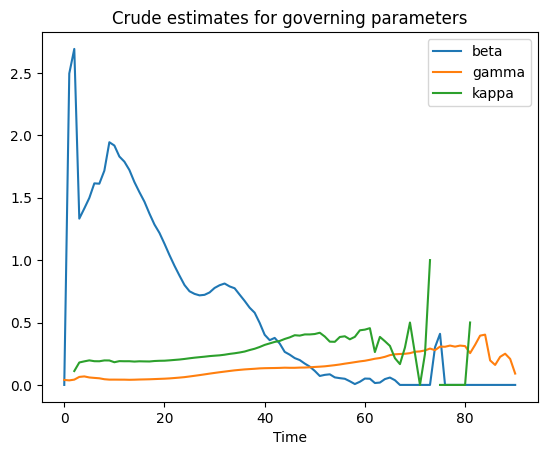

In [11]:
plt.plot(times, beta_estimate, label="beta")
plt.plot(times, gamma_estimate, label="gamma")
plt.plot(times, kappa_estimate_eq_3, label="kappa")
plt.xlabel("Time")
plt.legend()
plt.title("Crude estimates for governing parameters")
plt.savefig("NI_outputs/r_1/crude_estimates.png")

In [12]:
param_df = pd.DataFrame({"beta": beta_estimate, "gamma": gamma_estimate, "kappa_eq_3": kappa_estimate_eq_3,
                         "kappa_eq_2": kappa_estimate_eq_2})
param_df.replace(np.inf, 0, inplace=True)

# We replace any zeros with NaNs as these will not contribute to the beta, gamma and kappa values
param_df.replace(0, np.nan, inplace=True)
print(f"Mean beta: {np.mean(param_df["beta"])}, std dev beta: {np.std(param_df["beta"])}")
print(f"Mean gamma: {np.mean(param_df["gamma"])}, std dev gamma: {np.std(param_df["gamma"])}")
print(f"Mean kappa (eq 2): {np.mean(param_df["kappa_eq_2"])}, std dev kappa (eq 2): {np.std(param_df["kappa_eq_2"])}")
print(f"Mean kappa (eq 3): {np.mean(param_df["kappa_eq_3"])}, std dev kappa (eq 3): {np.std(param_df["kappa_eq_3"])}")

Mean beta: 0.7626132760045915, std dev beta: 0.6729028390938536
Mean gamma: 0.15181968555984324, std dev gamma: 0.09306306854428105
Mean kappa (eq 2): 0.2919818274286646, std dev kappa (eq 2): 0.1255013264048805
Mean kappa (eq 3): 0.29198182742866463, std dev kappa (eq 3): 0.12550132640488054


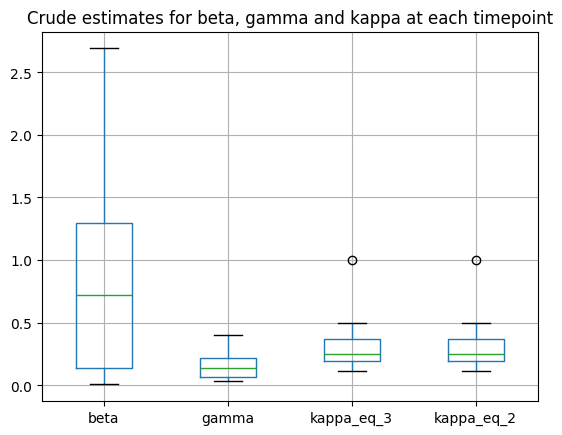

In [13]:
param_df.boxplot()
plt.title("Crude estimates for beta, gamma and kappa at each timepoint")
plt.savefig("NI_outputs/r_1/crude_estimates_boxplot.png")

### Crude estimate of $R_t$

Now we will move on to estimating the value of $R_t$. The effective reproduction number, $R_t$, is defined as:

$$R_{t} = \frac{\beta(t)}{N\gamma(t)}S(t),$$

where $\beta(t)$ and $\gamma(t)$ are as defined previously, $N$ is the total population and $S(t)$ is the number of susceptible people at time $t$.

In [14]:
crude_R_t = param_df['beta'] * susceptible / (pop_size * param_df['gamma'])
mean_crude_R_t = np.mean(param_df['beta']) * susceptible / (pop_size * np.mean(param_df['gamma']))

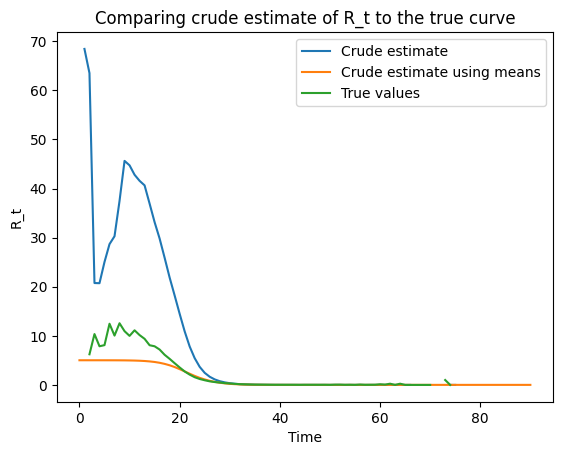

In [15]:
plt.plot(times, crude_R_t, label='Crude estimate')
plt.plot(times, mean_crude_R_t, label='Crude estimate using means')
plt.plot(times, secondary_infections_data['R_t'], label='True values')
plt.xlabel("Time")
plt.ylabel("R_t")
plt.legend()
plt.title("Comparing crude estimate of R_t to the true curve")
plt.savefig("NI_outputs/r_1/crude_R_t.png")

## Model Inference

### Set up

First, we normalise the data. Here is a description of our parameters:
* $S(0)$, $E(0)$, $I(0)$, $R(0)$ - Initial $S$, $E$, $I$ and $R$ values
* $\beta$, $\kappa$, $\gamma$ - Infection Rate, Incubation Rate and Recovery Rate respectively
* $\sigma_{S}$, $\sigma_{E}$, $\sigma_{I}$, $\sigma_{R}$ - The 4 hyperparameters controlling each respective log prior

In [16]:
all_data = np.array([susceptible, exposed, infected, recovered]).transpose()
pop_size = 1837198
initial_infected = 100
all_data = all_data / pop_size

### PINTS ForwardModel

Next, we create the forward model used to perform inference. We will be using a `ReducedModel` from `seirmo` to fix/specify specific parameters
to reduce the dimensions of the parameter space. These values are described in the table below.

|Parameter|Value|Reasoning|
|---|---|-------|
|$S(0)$|$1 - I(0)$|The total of all compartments must add up to $1$ for all time (after scaling out by `pop_size`).|
|$E(0)$|$0$|We can safely assume that no-one has been exposed at the start of the simulation.|
|$I(0)$|$\frac{100}{1837198}$|We know that there were $100$ initial infected, and we scale out by `pop_size`.|
|$R(0)$|$0$|We also enforce that no-one has recovered at the start of the simulation.|
|$\kappa$|$0.292$|From the reasoning in the crude estimates section, we fix $\kappa$ at this value.|

In [17]:
import seirmo
import pints

class SEIRModel1(pints.ForwardModel):
    def __init__(self):
        super(SEIRModel1, self).__init__()

        seir_model = seirmo.SEIRModel()
        self._model = seirmo.ReducedModel(seir_model)
        fixed_parameters = {"E0": 0, "R0": 0}
        self._model.fix_parameters(fixed_parameters)

    def n_outputs(self):
        # Returns number of model outputs.
        # Returns the S, E, I and R values at each timestep
        return 4

    def n_parameters(self):
        # Returns number of parameters, i.e. I(0), beta, kappa and gamma
        return 4

    def n_fixed_parameters(self):
        # Returns number of fixed parameters, i.e. 3 initial conditions (S(0), E(0), and R(0))
        return 3

    def simulate(self, parameters, times):
        # This ensures that we are taking the prevalence
        self._model.set_outputs(["S", "E", "I", "R"])
        parameters = np.insert(parameters, 0, 1 - parameters[0])
        compartmental_results = self._model.simulate(parameters=parameters, times=times)

        return compartmental_results

In [18]:
import seirmo
import pints

class SEIRModel2(pints.ForwardModel):
    def __init__(self, pop_size, initial_infected, kappa = None):
        super(SEIRModel2, self).__init__()

        seir_model = seirmo.SEIRModel()
        self._model = seirmo.ReducedModel(seir_model)
        fixed_parameters = {"S0": 1 - initial_infected / pop_size, "E0": 0, "I0": initial_infected / pop_size, "R0": 0}
        if kappa:
            fixed_parameters["beta"] = kappa
        self._model.fix_parameters(fixed_parameters)
        self._kappa = kappa

    def n_outputs(self):
        # Returns number of model outputs.
        # Returns the S, E, I and R values at each timestep
        return 4

    def n_parameters(self):
        # Returns number of parameters, i.e. some of beta, kappa and gamma
        if self._kappa:
            return 2
        return 3

    def n_fixed_parameters(self):
        # Returns number of fixed parameters, i.e. 4 initial conditions (S(0), E(0), I(0) and R(0)) and potentially kappa
        if self._kappa:
            return 5
        return 4

    def simulate(self, parameters, times):
        # This ensures that we are taking the prevalence
        self._model.set_outputs(["S", "E", "I", "R"])
        compartmental_results = self._model.simulate(parameters=parameters, times=times)

        return compartmental_results

In [19]:
pints_model = SEIRModel2(pop_size=pop_size, initial_infected=initial_infected)
problem = pints.MultiOutputProblem(pints_model, times, all_data)

C:\Users\matth\AppData\Local\Temp\ipykernel_19812\3712193169.py:13: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._model.fix_parameters(fixed_parameters)


### Optimisation

We now will use the optimiser to reach some realistic parameter values.

In [20]:
boundaries = pints.RectangularBoundaries([0.01, 0.01, 0.01],
                                         [4, 4, 4])
log_prior = pints.UniformLogPrior(boundaries)

C:\Users\matth\AppData\Local\Temp\ipykernel_19812\3366709189.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(boundaries)


In [21]:
num_opts = 10
score = pints.SumOfSquaresError(problem)
param_names = ["beta", "kappa", "gamma"]

In [95]:
for j in range(num_opts):
    xs = log_prior.sample(1)
    opt = pints.OptimisationController(score, xs, boundaries=boundaries, method=pints.CMAES)
    opt.set_max_unchanged_iterations(200, 0.00000001)
    opt.set_max_iterations(2500)
    opt_params, opt_values = opt.run()
    opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(pints_model.n_parameters())})
    opt_param_df.to_csv(f"optimisation_outputs/r_0_2/opt_params_{j}.csv")

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time m:s
0     7      21.88166  21.88166   0:00.1
1     14     14.98015  14.98015   0:00.2
2     21     8.954415  8.954415   0:00.2
3     28     5.710416  5.710416   0:00.3
20    147    3.498837  3.737157   0:01.0
40    287    3.476604  3.480282   0:01.7
60    427    3.474426  3.474426   0:02.3
80    567    3.467144  3.467144   0:03.0
100   707    3.466027  3.466027   0:03.7
120   847    3.464503  3.464503   0:04.5
140   987    3.464291  3.464306   0:05.3
160   1127   3.464282  3.464282   0:06.1
180   1267   3.464282  3.464282   0:06.8
200   1407   3.464282  3.464282   0:07.6
220   1547   3.464282  3.464282   0:08.3
240   1687   3.464282  3.464282   0:09.0
260   1827   3.464282  3.464282   0:09.8
280   1967   3.464282  3.464282   0:10.6
300   2107   3.464282  3.464282   0:11.4
320   2247   3.464282  3.464282   0:12.4
340 

### Plotting with optimised parameters 

In [22]:
opt_params = []
num_opts = 10
for j in range(num_opts):
    opt_param_df = pd.read_csv(f"optimisation_outputs/r_1/opt_params_{j}.csv", index_col=0)
    opt_params.append(opt_param_df.to_numpy()[0])

In [23]:
errors = []
# true_error = score(parameters)
# print("---------------------------------------------------------------------------")
# print(f"True parameters, sum of squared errors = {round(true_error, 5)}")
for j in range(num_opts):
    print("---------------------------------------------------------------------------")
    error = score(opt_params[j])
    print(f"Optimisation {j}, sum of squared errors = {round(error, 5)}")
    print("---------------------------------------------------------------------------")
    errors.append(error)
    output_list = []
    for i in range(pints_model.n_parameters()):
        opt_param = round(opt_params[j][i], 5)
        output_list.append(opt_param)
        print(f"Parameter: {param_names[i]}, Optimised: {opt_param}")

---------------------------------------------------------------------------
Optimisation 0, sum of squared errors = 0.1547
---------------------------------------------------------------------------
Parameter: beta, Optimised: 1.41825
Parameter: kappa, Optimised: 0.23202
Parameter: gamma, Optimised: 0.10148
---------------------------------------------------------------------------
Optimisation 1, sum of squared errors = 0.1547
---------------------------------------------------------------------------
Parameter: beta, Optimised: 1.41825
Parameter: kappa, Optimised: 0.23202
Parameter: gamma, Optimised: 0.10148
---------------------------------------------------------------------------
Optimisation 2, sum of squared errors = 0.1547
---------------------------------------------------------------------------
Parameter: beta, Optimised: 1.41825
Parameter: kappa, Optimised: 0.23202
Parameter: gamma, Optimised: 0.10148
-------------------------------------------------------------------------

In [24]:
chosen_opt = 0

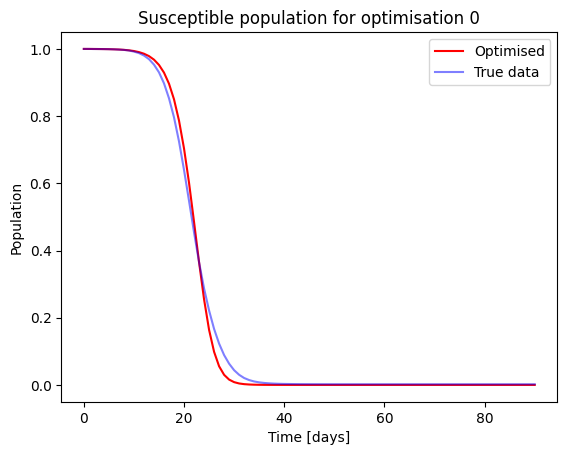

In [25]:
opt_soln = pints_model.simulate(opt_params[chosen_opt], times)
# opt_soln = model.simulate(parameters, times)

opt_S, opt_E, opt_I, opt_R = opt_soln[:, 0], opt_soln[:, 1], opt_soln[:, 2], opt_soln[:, 3]
# opt_V = opt_soln[:, 0]
plt.plot(times, opt_S, "-r", label="Optimised")
plt.plot(times, susceptible / pop_size, "-b", alpha=0.5, label="True data")
plt.xlabel("Time [days]")
plt.ylabel("Population")
plt.legend()
plt.title(f"Susceptible population for optimisation {chosen_opt}")
plt.savefig(f"optimisation_outputs/r_1/susceptible_{chosen_opt}.png")

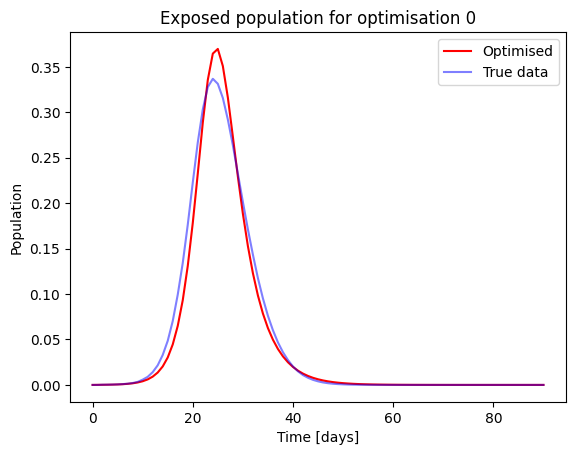

In [26]:
plt.plot(times, opt_E, "-r", label="Optimised")
plt.plot(times, exposed / pop_size, "-b", alpha=0.5, label="True data")
plt.xlabel("Time [days]")
plt.ylabel("Population")
plt.legend()
plt.title(f"Exposed population for optimisation {chosen_opt}")
plt.savefig(f"optimisation_outputs/r_1/exposed{chosen_opt}.png")

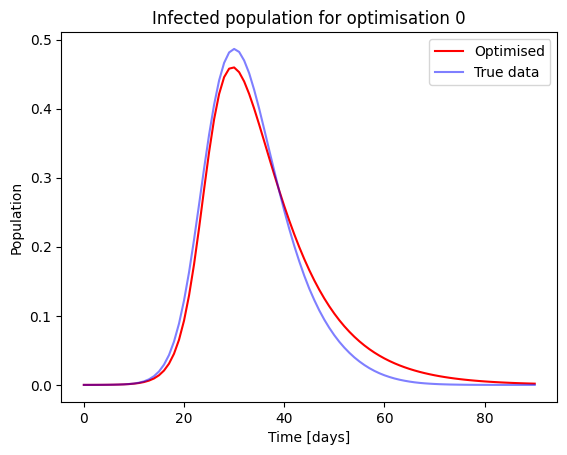

In [27]:
plt.plot(times, opt_I, "-r", label="Optimised")
plt.plot(times, infected / pop_size, "-b", alpha=0.5, label="True data")
plt.xlabel("Time [days]")
plt.ylabel("Population")
plt.legend()
plt.title(f"Infected population for optimisation {chosen_opt}")
plt.savefig(f"optimisation_outputs/r_1/infected_{chosen_opt}.png")

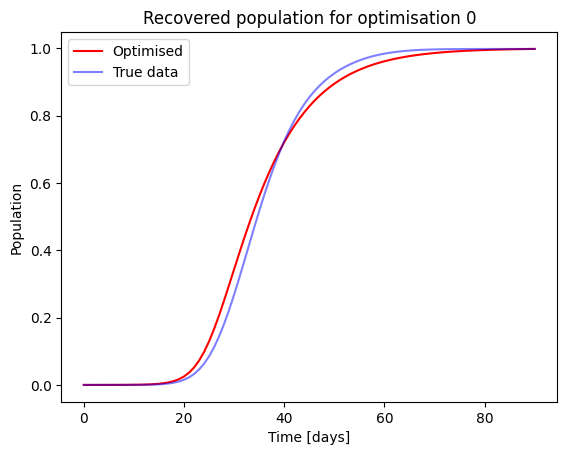

In [28]:
plt.plot(times, opt_R, "-r", label="Optimised")
plt.plot(times, recovered / pop_size, "-b", alpha=0.5, label="True data")
plt.xlabel("Time [days]")
plt.ylabel("Population")
plt.legend()
plt.title(f"Recovered population for optimisation {chosen_opt}")
plt.savefig(f"optimisation_outputs/r_1/recovered_{chosen_opt}.png")

### PINTS `MultiOutputProblem` and `GaussianLogLikelihood`

We choose a Gaussian log-likelihood and an array of Gaussian log-priors for each of the different parameters of the model.

In [29]:
# Create log-likelihood
log_likelihood = pints.GaussianLogLikelihood(problem)

In [30]:
# Create log-prior and log-posterior
composed_log_prior = pints.ComposedLogPrior(
    log_prior,
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf)
)
log_posterior = pints.LogPosterior(log_likelihood, composed_log_prior)

### Initialising multiple starting locations for the chain

In [31]:
num_chains = 4
xs = np.tile(np.array(opt_params[chosen_opt].tolist() + [0.1, 0.1, 0.1, 0.1]), (4, 1))
print(xs)
transform = pints.RectangularBoundariesTransformation([0.01, 0.01, 0.01, 0, 0, 0, 0],
                                                      [4, 4, 4, 1, 1, 1, 1])

[[1.41825039 0.23201546 0.10148184 0.1        0.1        0.1
  0.1       ]
 [1.41825039 0.23201546 0.10148184 0.1        0.1        0.1
  0.1       ]
 [1.41825039 0.23201546 0.10148184 0.1        0.1        0.1
  0.1       ]
 [1.41825039 0.23201546 0.10148184 0.1        0.1        0.1
  0.1       ]]


### Performing inference

In [122]:
n_params = log_prior.n_parameters()
mcmc = pints.MCMCController(log_posterior, num_chains, xs, transformation=transform)
max_iterations = 50000
mcmc.set_max_iterations(max_iterations)

chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval.  Accept.   Accept.   Accept.   Accept.   Time m:s
0     4       0         0         0         0          0:00.0
1     8       0         0         0         0          0:00.1
2     12      0.333     0         0.333     0          0:00.1
3     16      0.5       0         0.25      0          0:00.1
20    84      0.143     0         0.0952    0.0952     0:00.6
40    164     0.0976    0.0244    0.122     0.146      0:01.2
60    244     0.082     0.0164    0.082     0.131      0:01.8
80    324     0.0617    0.037     0.0988    0.111      0:02.4
100   404     0.0495    0.0594    0.0792    0.129      0:03.0
120   484     0.0496    0.0579    0.0826    0.132      0:03.7
140   564     0.0496    0.0496    0.078     0.121      0:04.3
160   644     0.0497    0.0435    0.0683    0.106      0:04.9
180   724     0.0442    0.0387    0.0608    0.0994     0:05.5
Initial phase completed.
200   804  

### Saving chains

In [32]:
param_names = ['Infection Rate (beta)', 'Incubation Rate (kappa)', 'Recovery Rate (gamma)',
               'sigma_S', 'sigma_E', 'sigma_I', 'sigma_R']

In [124]:
for i, chain in enumerate(chains):
    df = pd.DataFrame(chain, columns=param_names)
    df.to_csv(f"chain_data/r_0_2/chain_{i}.csv")

## Plots

### Recovering chains from .csv files

In [33]:
list_of_chains = []
for i in range(4):
    df = pd.read_csv(f"chain_data/r_1/chain_{i}.csv", index_col=0)
    chain = df.to_numpy()
    list_of_chains.append(chain)
chains = np.array(list_of_chains)

### Trace plots

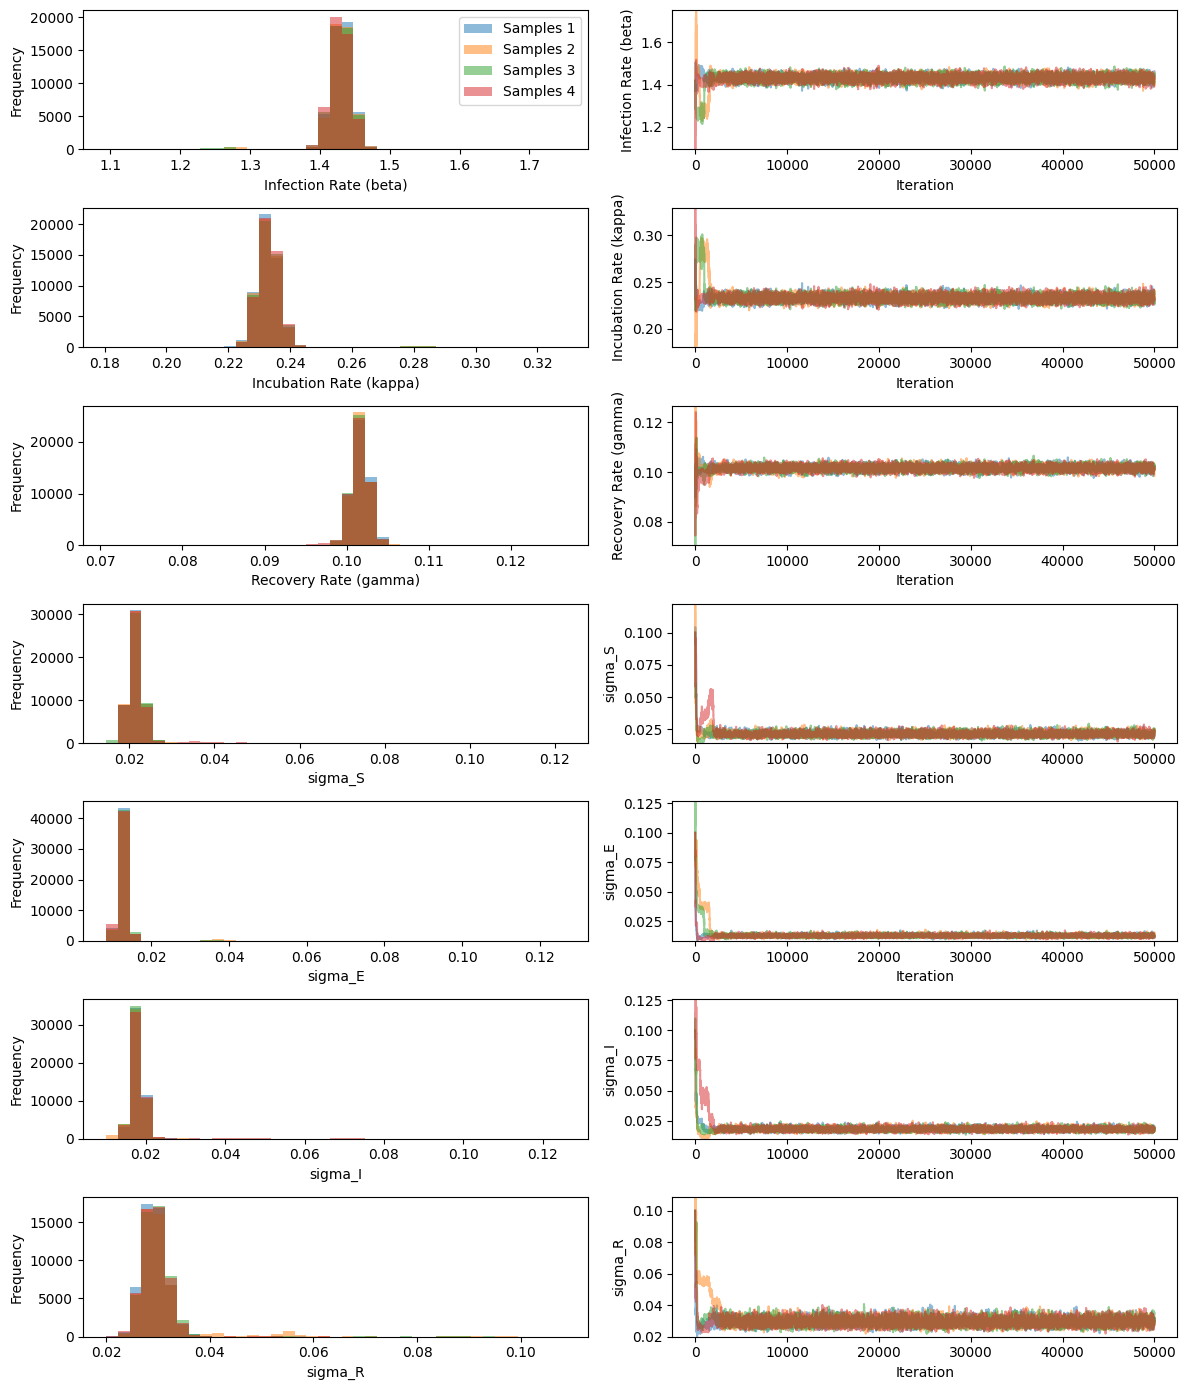

In [34]:
import pints.plot
pints.plot.trace(chains, parameter_names=param_names)
plt.show()

In [91]:
# chains = chains[:3, :]

### Diagnosing using $\hat{R}$

Here we find the $\hat{R}$ measure for the inference for all different parameters. For well mixed and stationary chains, $\hat{R}$ is close to $1$.

In [35]:
r_hat_values = pints.rhat(chains, warm_up=0.5)
for i in range(len(param_names)):
    print(f"R_hat value for {param_names[i]}: {round(r_hat_values[i], 5)}")

R_hat value for Infection Rate (beta): 1.00117
R_hat value for Incubation Rate (kappa): 1.001
R_hat value for Recovery Rate (gamma): 1.00052
R_hat value for sigma_S: 1.00041
R_hat value for sigma_E: 1.00111
R_hat value for sigma_I: 1.0004
R_hat value for sigma_R: 1.00113


We will now discount the first half of the iterations.

In [36]:
max_iterations = 50000
chains = chains[:, int(max_iterations / 2):]

### Predicted time series plots

#### Chain 1

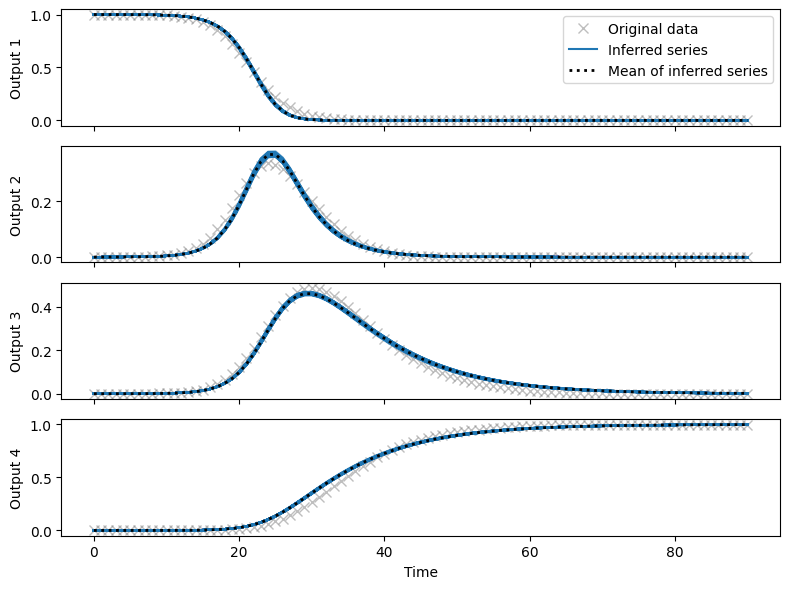

In [37]:
pints.plot.series(chains[0, :], problem)
plt.show()

#### Chain 2

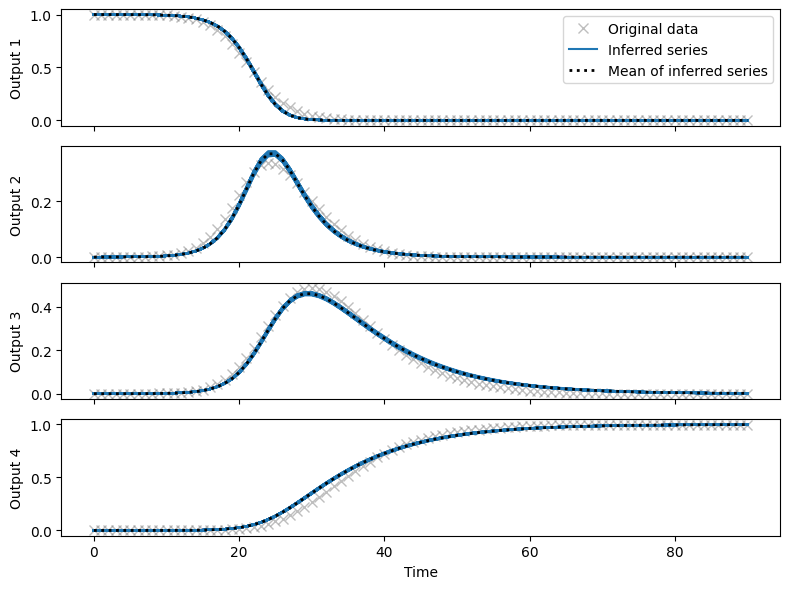

In [38]:
pints.plot.series(chains[1, :], problem)
plt.show()

#### Chain 3

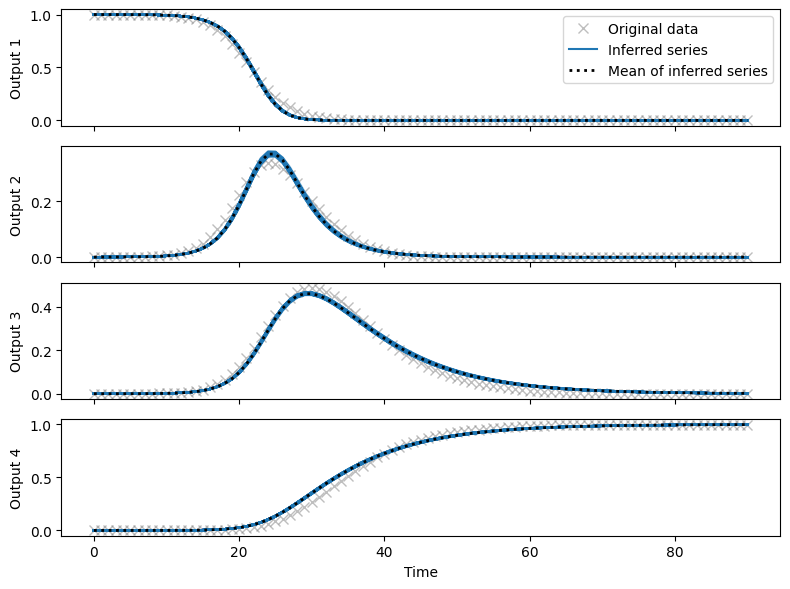

In [39]:
pints.plot.series(chains[2, :], problem)
plt.savefig("inference_outputs/r_1/series.png")

#### Chain 4

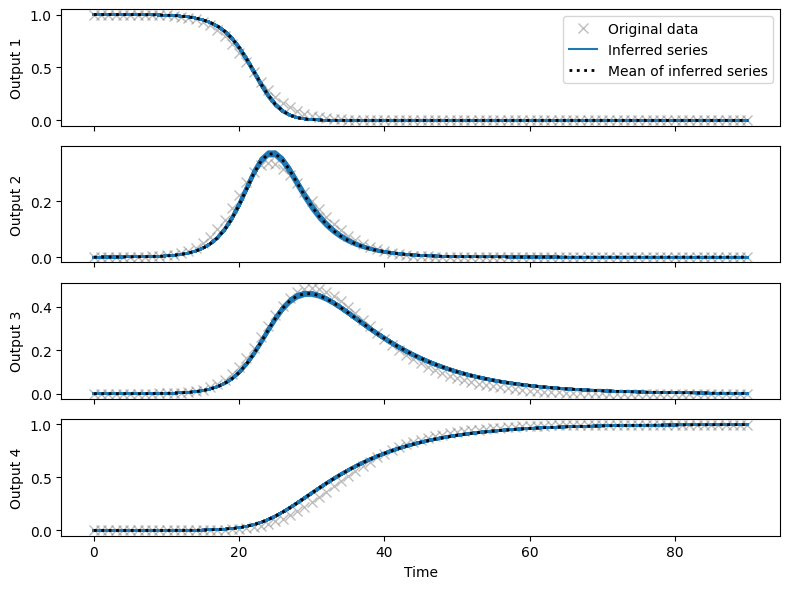

In [40]:
pints.plot.series(chains[3, :], problem)
plt.show()

In [41]:
print(chains.shape)

(4, 25000, 7)


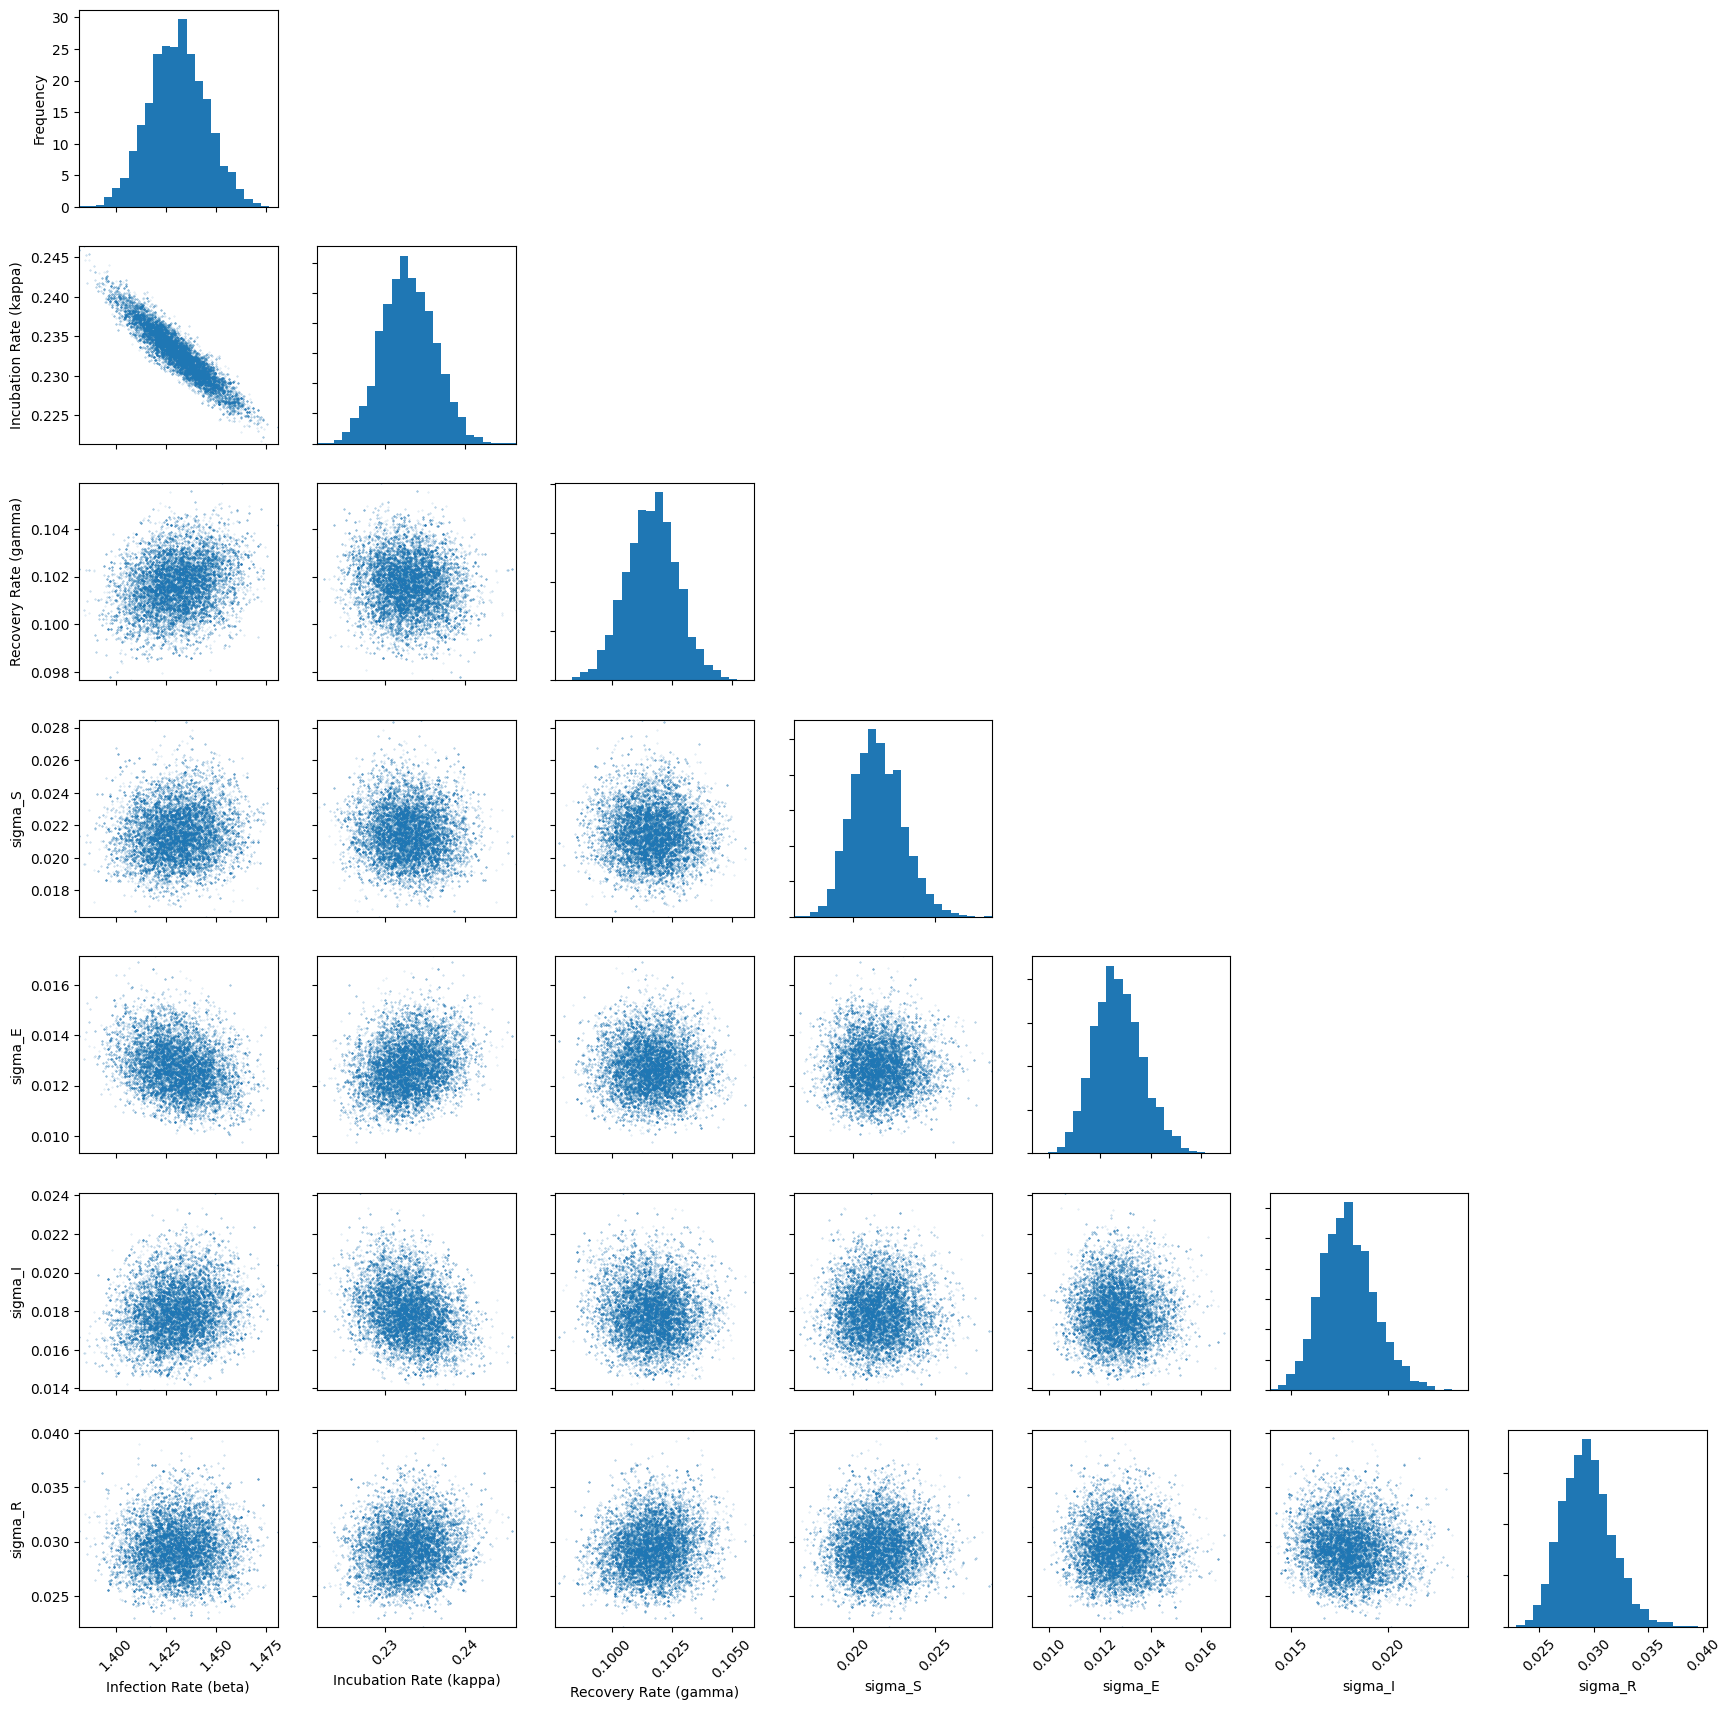

In [42]:
pints.plot.pairwise(chains[0, :], parameter_names=param_names)
plt.savefig("inference_outputs/r_1/pairwise.png")

## Estimating $R_t$

Now we will move on to estimating the value of $R_t$. The effective reproduction number, $R_t$, is defined as:

$$R_{t} = \frac{\beta}{\gamma N}S(t),$$

where $\beta$ and $\gamma$ are as defined previously, $N$ is the total population and $S(t)$ is the number of susceptible people at time $t$.

### Rescaling and extracting $\beta$ and $\gamma$

In [43]:
param_names = ["Infection Rate (beta)", "Incubation Rate (kappa)", "Recovery Rate (gamma)", "sigma_S", "sigma_E", "sigma_I", "sigma_R"]
chains_df = pd.DataFrame(columns=param_names + ['chain'])
for i in range(4):
    chain_i_df = pd.DataFrame(chains[i], columns=param_names)
    for population_parameter in ["sigma_S", "sigma_E", "sigma_I", "sigma_R"]:
        chain_i_df[population_parameter] = pop_size * chain_i_df[population_parameter]
    chain_i_df['chain'] = [i] * len(chain_i_df)
    chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_19812\1752131243.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)


Mean beta: 1.4308052583782218, std dev beta: 0.01421122299337935
Mean gamma: 0.10164014949750917, std dev gamma: 0.0010454088027645793
Mean kappa: 0.23283510447762285, std dev kappa: 0.003315763510428863


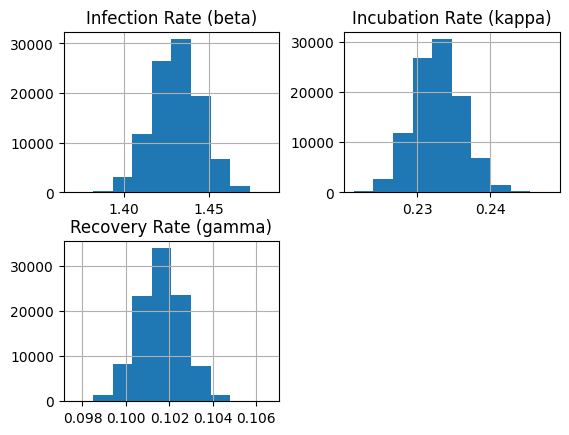

In [44]:
beta_posterior = chains_df["Infection Rate (beta)"].to_numpy()
gamma_posterior = chains_df["Recovery Rate (gamma)"].to_numpy()
kappa_posterior = chains_df["Incubation Rate (kappa)"].to_numpy()
print(f"Mean beta: {np.mean(chains_df["Infection Rate (beta)"])}," 
      f" std dev beta: {np.std(chains_df["Infection Rate (beta)"])}")
print(f"Mean gamma: {np.mean(chains_df["Recovery Rate (gamma)"])}," 
      f" std dev gamma: {np.std(chains_df["Recovery Rate (gamma)"])}")
print(f"Mean kappa: {np.mean(chains_df["Incubation Rate (kappa)"])}," 
      f" std dev kappa: {np.std(chains_df["Incubation Rate (kappa)"])}")
num_rows, num_columns = 2, 2
num_params = 3
crude_param_names = ["beta", "kappa_eq_2", "gamma"]
histograms = chains_df.hist(column=["Infection Rate (beta)", "Incubation Rate (kappa)", "Recovery Rate (gamma)"])
for row in range(num_rows):
    figs_in_row = num_columns
    if row == num_rows - 1:
        r = num_params % num_columns
        figs_in_row = r if r != 0 else num_params
    for column in range(figs_in_row):
        index = row * num_columns + column
        ax = histograms[row][column]
        crude_params = param_df[crude_param_names[index]]
        # ax.hist(crude_params, alpha=0.4, label="Crude")
        # ax.axvline(np.mean(crude_params), color='r', linestyle='dashed', linewidth=1, label="Crude mean")
# ax.legend()
plt.title("Posterior distributions for the governing parameters")
plt.savefig("inference_outputs/r_1/posteriors.png")

In [45]:
import random

### Contingency table for secondary infections

In [46]:
max_secondary_infections = 50
final_active_day = 80
times = np.array(secondary_infections_data["time"], dtype="int8")
secondary_infections = secondary_infections_data.iloc[:, 1:-1].to_numpy()
contingency_list = []
for t in times[:final_active_day + 1]:
    print(f"Day {t}", end=" ")
    t_list = [0] * (max_secondary_infections + 1)
    secondary_infections_t = secondary_infections[t, :]
    secondary_infections_t = secondary_infections_t[~np.isnan(secondary_infections_t)]
    for entry in secondary_infections_t:
        if entry <= max_secondary_infections:
            t_list[int(entry)] += 1
    contingency_list.append(t_list)
contingency_array = np.array(contingency_list).transpose()
contingency_df = pd.DataFrame(contingency_array, columns=times[:final_active_day + 1])
contingency_df.to_csv("NI_outputs/r_1/contingency.csv")

Day 0 Day 1 Day 2 Day 3 Day 4 Day 5 Day 6 Day 7 Day 8 Day 9 Day 10 Day 11 Day 12 Day 13 Day 14 Day 15 Day 16 Day 17 Day 18 Day 19 Day 20 Day 21 Day 22 Day 23 Day 24 Day 25 Day 26 Day 27 Day 28 Day 29 Day 30 Day 31 Day 32 Day 33 Day 34 Day 35 Day 36 Day 37 Day 38 Day 39 Day 40 Day 41 Day 42 Day 43 Day 44 Day 45 Day 46 Day 47 Day 48 Day 49 Day 50 Day 51 Day 52 Day 53 Day 54 Day 55 Day 56 Day 57 Day 58 Day 59 Day 60 Day 61 Day 62 Day 63 Day 64 Day 65 Day 66 Day 67 Day 68 Day 69 Day 70 Day 71 Day 72 Day 73 Day 74 Day 75 Day 76 Day 77 Day 78 Day 79 Day 80 

In [47]:
contingency_array = pd.read_csv("NI_outputs/r_1/contingency.csv", index_col=0).to_numpy()
print(contingency_array)

[[27  0  4 ...  0  0  0]
 [20  0  4 ...  0  0  0]
 [17  0  3 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  0  0]]


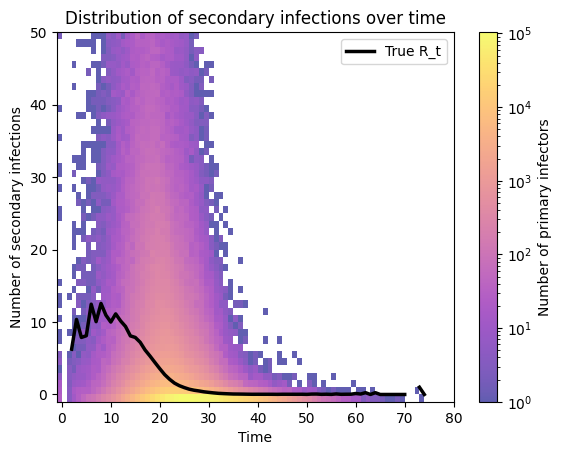

In [48]:
active_times = np.arange(-0.5, final_active_day, 1)
frequencies = np.arange(-0.5, max_secondary_infections, 1)
fig, ax = plt.subplots()
cf = ax.pcolormesh(active_times, frequencies, contingency_array[:, :final_active_day + 1],
                   alpha=0.65, cmap='plasma',
                   norm=matplotlib.colors.LogNorm())
ax.plot(secondary_infections_data["time"][:final_active_day + 1], 
        secondary_infections_data["R_t"][:final_active_day + 1], 'k', 
        lw=2.5, label="True R_t")
fig.colorbar(cf, label="Number of primary infectors")
ax.set_xlabel("Time")
ax.set_ylabel("Number of secondary infections")
ax.set_title("Distribution of secondary infections over time")
ax.legend()
fig.savefig("NI_outputs/r_1/secondary_infections_mesh.png")

### Plotting expected and actual $R_t$ values

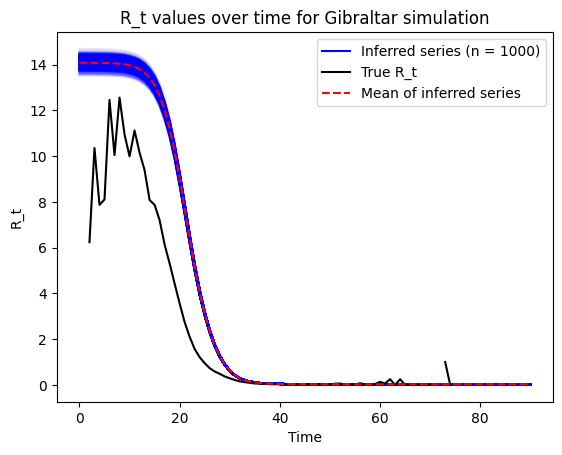

In [49]:
# cf = plt.pcolormesh(active_times, frequencies, contingency_array,
#                alpha=0.8, cmap='viridis',
#                norm=matplotlib.colors.LogNorm())
R_t_list = []
num_samples = 1000
for j in range(num_samples):
    k = random.randint(0, len(beta_posterior))
    R_t_list.append(beta_posterior[k] / (gamma_posterior[k] * pop_size) * susceptible)
    if j == 0:
        plt.plot(times, R_t_list[j][:91], 'b', label=f"Inferred series (n = {num_samples})")
    else:
        plt.plot(times, R_t_list[j][:91], 'b', alpha=0.1)
mean_R_t = np.mean(np.array(R_t_list), axis=0)
std_dev_R_t = np.std(np.array(R_t_list), axis=0)
plt.plot(times, secondary_infections_data["R_t"][:91], 'k', 
         label="True R_t")
plt.plot(times, mean_R_t[:91], '--r', label="Mean of inferred series")
plt.xlabel("Time")
plt.ylabel("R_t")
plt.title("R_t values over time for Gibraltar simulation")
plt.legend()
# plt.colorbar(cf)
# plt.show()
plt.savefig("inference_outputs/r_1/inferred_R_t.png")